In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
import catboost
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [172]:
# cargamos el dataset
bdif = pd.read_excel("bdif_modelo_2017.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


In [173]:
# para poder recuperarlo
bdif_save = bdif.copy()

### Aplicamos el mapeo de clases para la variable objetivo

In [174]:
# Crear un diccionario para mapear las clases a valores específicos
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    339190
1    237218
2      2008
Name: count, dtype: int64

In [175]:
# Separamos el dataset para usarlo para el entrenamiento del modelo
bdif_modelo = bdif[bdif['año'] <= 2016]
bdif_modelo.shape

(570372, 30)

### Preprocesamiento de los datos

In [176]:
# Seleccionamos las variables numéricas y categóricas 
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Aplicamos las transformaciones para cada tipo de variable
prep = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False), categoricas),])

# Creamos el pipeline
pipeline = Pipeline(steps=[('prep', prep)])

# Introducimos los datos de entrada
X = bdif_modelo.drop(columns=['claseincendio'])

# Ajustar el Pipeline a los datos y transformar
X_prep = pipeline.fit_transform(X)

# Lo pasamos a dataframe
X_prepdf = pd.DataFrame(X_prep, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_prepdf.filter(regex='^cat').columns
X_prepdf[dummies] = X_prepdf[dummies].astype(int)

# Eliminamos los prefijos
X_prepdf.columns = X_prepdf.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Reconstruimos el dataset y lo mostramos
X_prepdf['claseincendio'] = bdif_modelo['claseincendio']
bdif_reconstruido = X_prepdf.copy()
bdif_reconstruido.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde,claseincendio
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,1,0,0,0,0,1,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,1,0,0,1,0,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,1,0,0,1,0,0,0,0,1,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,0,0,0,1,0,0,1,0,0,0


In [177]:
# Tomamos el dataset con las caracteristicas que nos interesan
bdif_reconstruido = bdif_reconstruido[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]
bdif_reconstruido.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.000014,0.462795,0.000166,0.703490,0.663822,1,0.068724,0.541667,0.517710,0,...,0,0,1,0,0,0,0,1,0,1
1,0.000006,0.637024,0.001347,0.731106,0.672918,1,0.421203,0.510417,0.335891,0,...,0,0,1,1,0,0,0,1,0,0
2,0.000018,0.571688,0.000341,0.760152,0.707177,1,0.067092,0.697917,0.351240,0,...,0,0,0,0,0,0,0,1,1,0
3,0.000145,0.662432,0.000563,0.699029,0.672143,1,0.256033,0.614583,0.664109,0,...,1,0,1,0,1,0,0,1,0,1
4,0.000076,0.575318,0.000141,0.714636,0.675420,1,0.089480,0.427083,0.410272,0,...,0,0,0,0,0,0,0,0,1,0


### CarBoost con el dataset submuestreado con ENN + Tomek Links

In [178]:
bdif_enn_tomek = pd.read_excel("bdif_submuestreado.xlsx")
bdif_enn_tomek.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.014306,0.618875,0.000183,0.559100,0.802846,0,0.265486,0.572917,0.543093,1,...,0,0,0,0,0,1,0,0,0,0
1,0.000358,0.542650,0.000068,0.523174,0.647512,0,0.000000,0.656250,0.418536,1,...,0,1,1,0,0,1,1,0,0,0
2,0.000269,0.802178,0.000060,0.574670,0.718691,0,0.378725,0.427083,0.236128,1,...,0,0,0,0,0,0,0,0,0,0
3,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0
4,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0


In [304]:
print(bdif_enn_tomek['claseincendio'].value_counts())

claseincendio
0    70482
1    26177
2     1966
Name: count, dtype: int64


In [180]:
bdif_save = bdif_enn_tomek.copy()

In [181]:
#bdif_enn_tomek = bdif_save.copy()

### Dataset submuestreado de clases mayoritarias y reducido aleatoriamente a la clase minoritaria

En este caso reducimos el número de muestras de las clases mayoritarias, conatos e incendios. Aunque estan siendo muy bien identificadas, el hecho de que tengamos tantas muestras en favor de esas clases, hace que la clase más importante no esté siendo clasificada, por ello, trataremos de balancear el dataset. 

Reducimos aleatoriamente las muestras de las clases conatos e incendios a un número fijo de muestras.

In [305]:
X = bdif_enn_tomek.drop(['claseincendio'], axis=1)
y = bdif_enn_tomek['claseincendio']

# Submuestreo aleatorio {0: int(2*y.value_counts()[2]), 1: int(1.5*y.value_counts()[2])}
rus = RandomUnderSampler(sampling_strategy={0: int(1.5*y.value_counts()[2]), 1: int(1.5*y.value_counts()[2])}, random_state=42)
X_res, y_res = rus.fit_resample(X, y)

bdif_sub = pd.concat([X_res, y_res], axis=1)
print(bdif_sub['claseincendio'].value_counts())

claseincendio
0    2949
1    2949
2    1966
Name: count, dtype: int64


Realizamos el sobremuestreo del gif con RandomOverSampler para balancear el dataset y tratar de acercarnos al número de muestras de las clases mayoritarias. El sobremuestreo lo realizamos sólo en el entrenamiento, el conjunto de test se deja intacto.

### Incrementamos la clase gif con SMOTE

In [306]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train_sob, y_train_sob)

# Comprobamos el balanceo de clases
print(f"Distribución de clases en el conjunto de entrenamiento después de SMOTE: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de SMOTE: Counter({2: 2366, 1: 2366, 0: 2366})
Distribución de clases en el conjunto de test: Counter({0: 618, 1: 583, 2: 372})


In [307]:
# Vamos a obtener un conjunto para validación del 80%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Importación de CatBoost

In [13]:
import joblib
# Cargar el modelo desde el archivo .pkl
best_model = joblib.load('best_CatBoost_model.pkl')
# Verificar si se cargó correctamente (opcional)
print("Modelo cargado correctamente:", best_model)

Modelo cargado correctamente: <catboost.core.CatBoostClassifier object at 0x000001DC1E295310>


### Validación cruzada

In [308]:
# Creamos el pool de datos para los distintos conjuntos
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool = Pool(X_test, y_test)

# Parámetros del modelo optimizados por Optuna
parametros = {
    'iterations': 400, # Eran 709 pero al detectar overfitting se reduce
    'learning_rate': 0.07629814459517262,
    'depth': 10,
    'l2_leaf_reg': 4.355777835208367,
    'random_strength': 3.8442029458960665,
    'loss_function': 'MultiClass',
    'custom_metric': ['Accuracy'],
    'verbose': 100,
    'early_stopping_rounds': 50,
    'use_best_model': True,
    'eval_metric': 'Accuracy'
}

# Validación cruzada
resultados_cv = cv(
    pool=train_pool,
    params=parametros,
    fold_count=5,
    partition_random_seed=42,
    verbose=False,
    plot=False
)

Training on fold [0/5]

bestTest = 0.854001759
bestIteration = 389

Training on fold [1/5]

bestTest = 0.8522427441
bestIteration = 340

Training on fold [2/5]

bestTest = 0.8538732394
bestIteration = 379

Training on fold [3/5]

bestTest = 0.8553791887
bestIteration = 220

Training on fold [4/5]

bestTest = 0.8571428571
bestIteration = 368



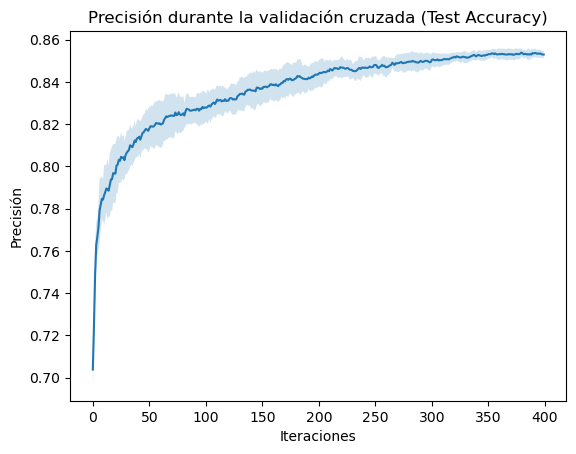

In [309]:
# Error promedio durante la validación cruzada
plt.plot(resultados_cv['iterations'], resultados_cv['test-Accuracy-mean'])
plt.fill_between(
    resultados_cv['iterations'],
    resultados_cv['test-Accuracy-mean'] - resultados_cv['test-Accuracy-std'],
    resultados_cv['test-Accuracy-mean'] + resultados_cv['test-Accuracy-std'],
    alpha=0.2
)
plt.xlabel('Iteraciones')
plt.ylabel('Precisión')
plt.title('Precisión durante la validación cruzada (Test Accuracy)')
plt.show()

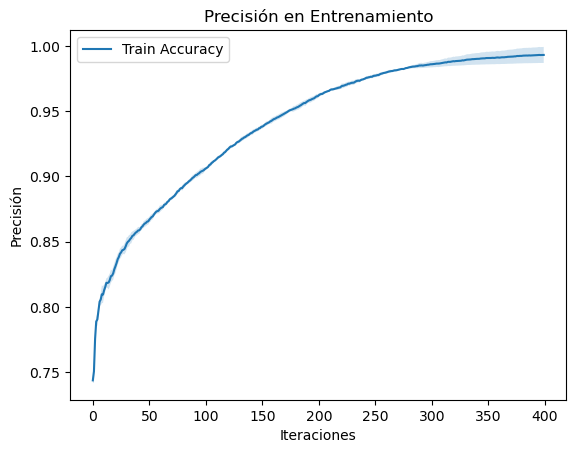

In [310]:
# Precisión en entrenamiento
plt.plot(resultados_cv['iterations'], resultados_cv['train-Accuracy-mean'], label='Train Accuracy')
plt.fill_between(
    resultados_cv['iterations'],
    resultados_cv['train-Accuracy-mean'] - resultados_cv['train-Accuracy-std'],
    resultados_cv['train-Accuracy-mean'] + resultados_cv['train-Accuracy-std'],
    alpha=0.2
)
plt.xlabel('Iteraciones')
plt.ylabel('Precisión')
plt.title('Precisión en Entrenamiento')
plt.legend()
plt.show()

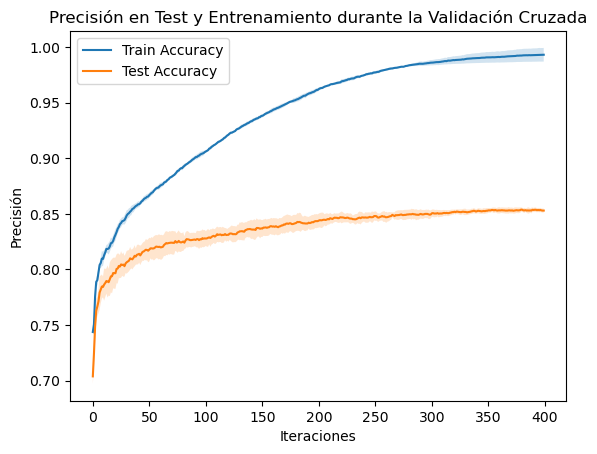

In [311]:
# Evitando el overfitting
plt.plot(resultados_cv['iterations'], resultados_cv['train-Accuracy-mean'], label='Train Accuracy')
plt.plot(resultados_cv['iterations'], resultados_cv['test-Accuracy-mean'], label='Test Accuracy')
plt.fill_between(
    resultados_cv['iterations'],
    resultados_cv['train-Accuracy-mean'] - resultados_cv['train-Accuracy-std'],
    resultados_cv['train-Accuracy-mean'] + resultados_cv['train-Accuracy-std'],
    alpha=0.2
)
plt.fill_between(
    resultados_cv['iterations'],
    resultados_cv['test-Accuracy-mean'] - resultados_cv['test-Accuracy-std'],
    resultados_cv['test-Accuracy-mean'] + resultados_cv['test-Accuracy-std'],
    alpha=0.2
)
plt.xlabel('Iteraciones')
plt.ylabel('Precisión')
plt.title('Precisión en Test y Entrenamiento durante la Validación Cruzada')
plt.legend()
plt.show()

In [312]:
# Crear el modelo final con los parámetros optimizados
modelo_optimizado = CatBoostClassifier(**parametros)

# Entrenar el modelo en todo el conjunto de entrenamiento con Early Stopping
modelo_optimizado.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.7256076	test: 0.6683099	best: 0.6683099 (0)	total: 72.7ms	remaining: 29s
100:	learn: 0.9015498	test: 0.8049296	best: 0.8063380 (96)	total: 6.93s	remaining: 20.5s
200:	learn: 0.9547376	test: 0.8154930	best: 0.8176056 (169)	total: 13.9s	remaining: 13.7s
300:	learn: 0.9834449	test: 0.8288732	best: 0.8288732 (297)	total: 20.5s	remaining: 6.74s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8330985915
bestIteration = 340

Shrink model to first 341 iterations.


In [313]:
# Evaluación en conjunto de validación
y_pred = modelo_optimizado.predict(X_val)
y_pred = np.ravel(y_pred)
accuracy = np.mean(y_pred == y_val)
print(f'Precisión en el conjunto de validación: {accuracy:.4f}')

Precisión en el conjunto de validación: 0.8331


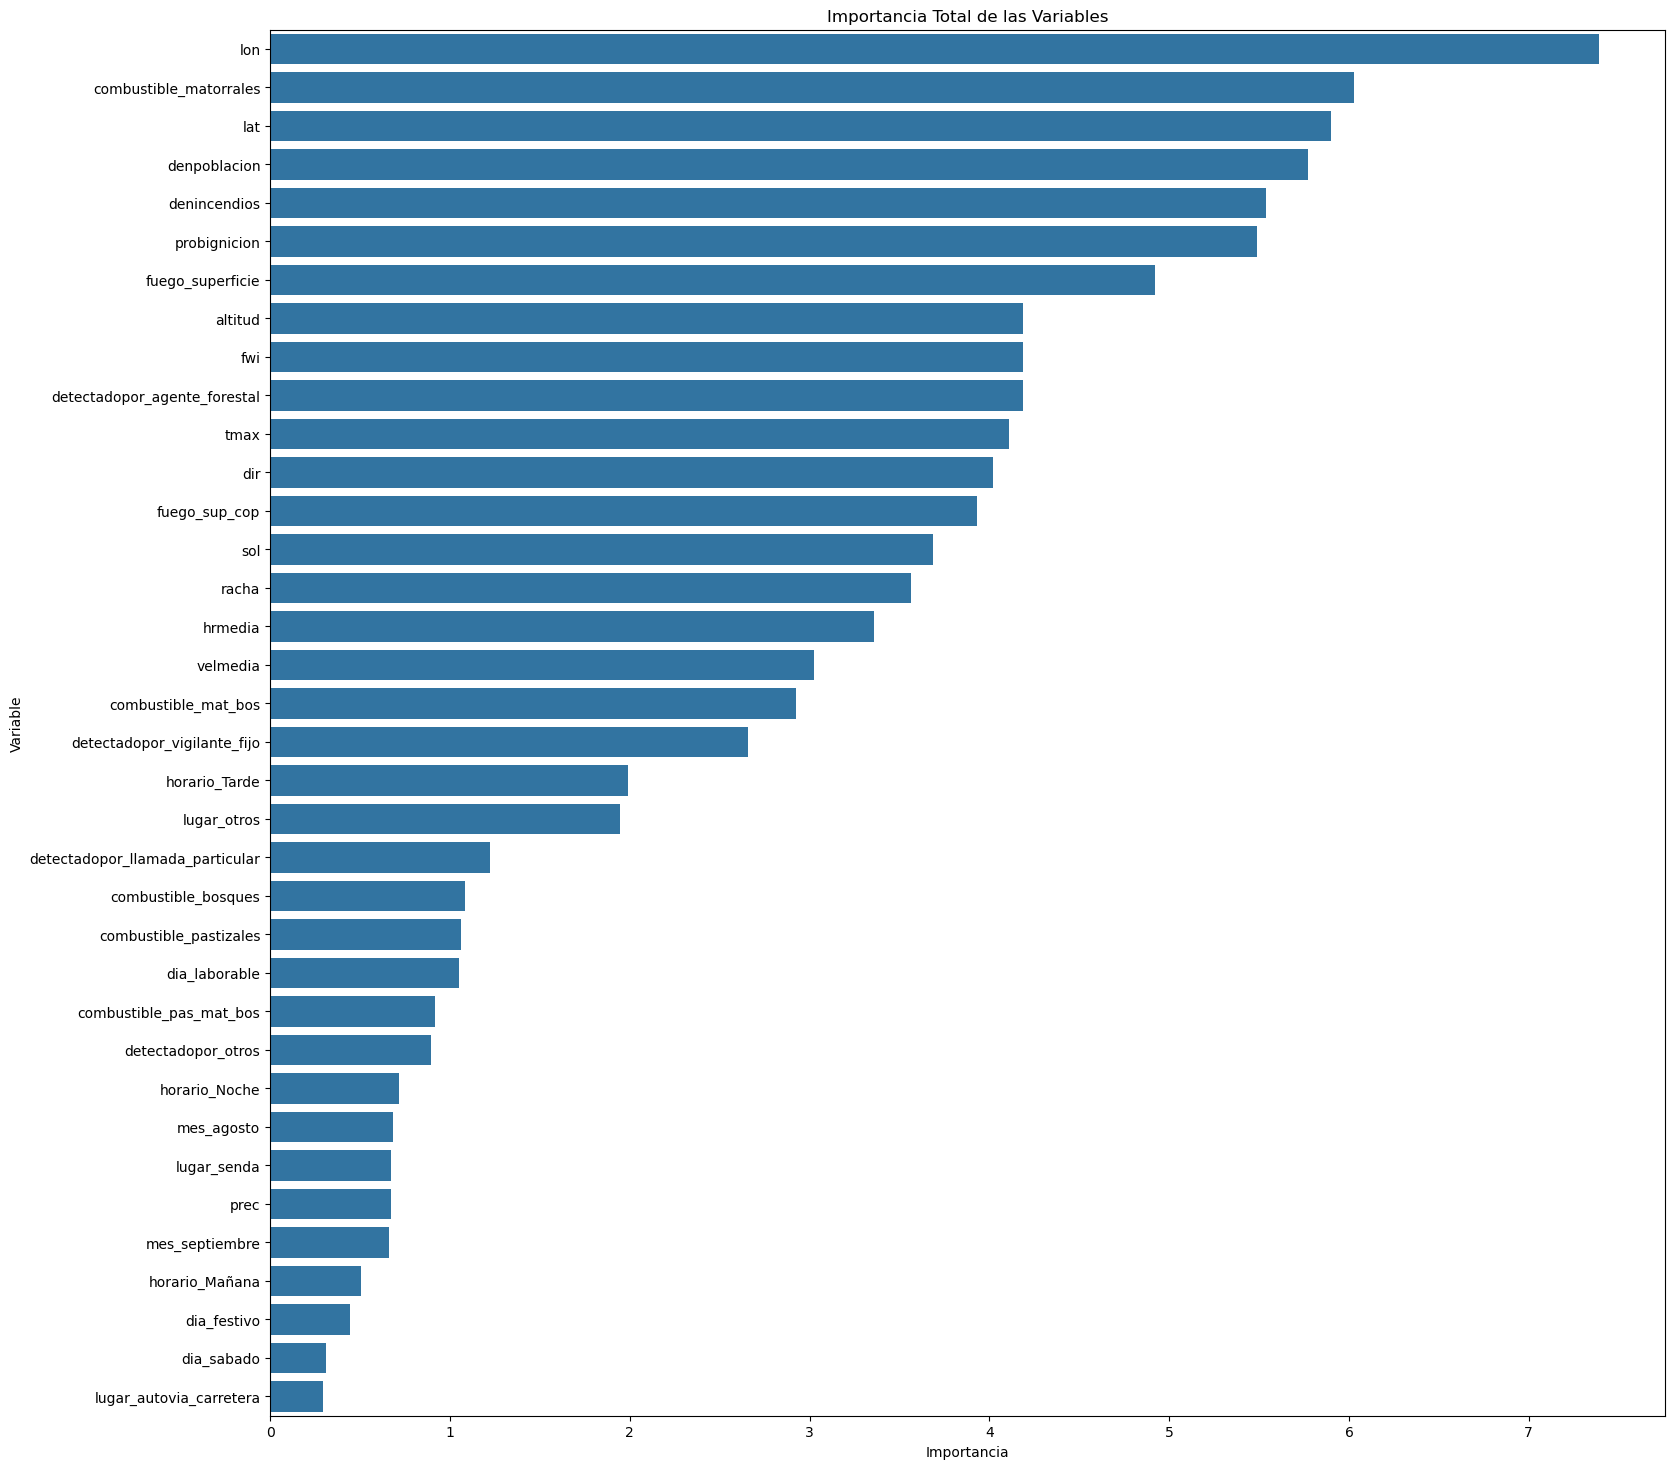

In [314]:
# Importancia de características
importancia = modelo_optimizado.get_feature_importance()

# Lo pasamos a dataframe
importancia = pd.DataFrame({
    'Variable': X_val.columns,
    'Importancia': importancia
})

# Lo ordenamos
importancia = importancia.sort_values(by='Importancia', ascending=False)

# Mostramos el grafico por importancia de variables
plt.figure(figsize=(18, 18))
sns.barplot(x='Importancia', y='Variable', data=importancia)
plt.title("Importancia Total de las Variables")
plt.show()

In [315]:
# Mostrar el reporte de clasificación
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       618
           1       0.84      0.79      0.81       583
           2       0.70      0.75      0.72       372

    accuracy                           0.84      1573
   macro avg       0.82      0.82      0.82      1573
weighted avg       0.84      0.84      0.84      1573



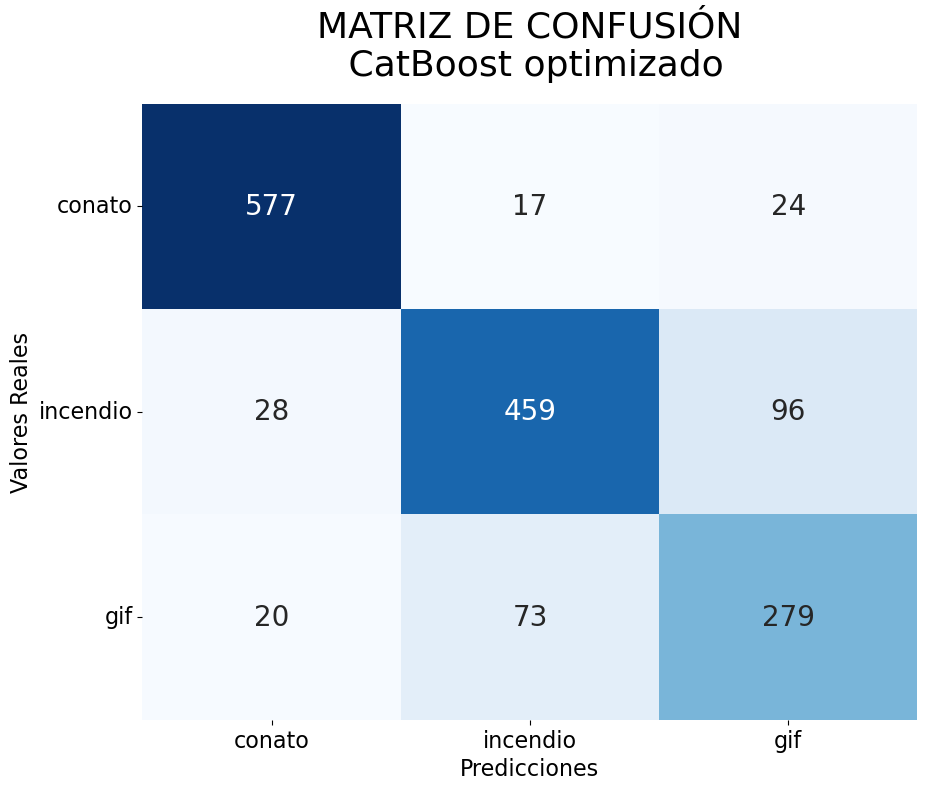

In [316]:
# Realizar predicciones finales y calcular la matriz de confusión
y_pred_final = modelo_optimizado.predict(X_test)

cm = confusion_matrix(y_test, y_pred_final, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20},cbar=False)

plt.title("MATRIZ DE CONFUSIÓN\n CatBoost optimizado", fontsize=26, pad=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

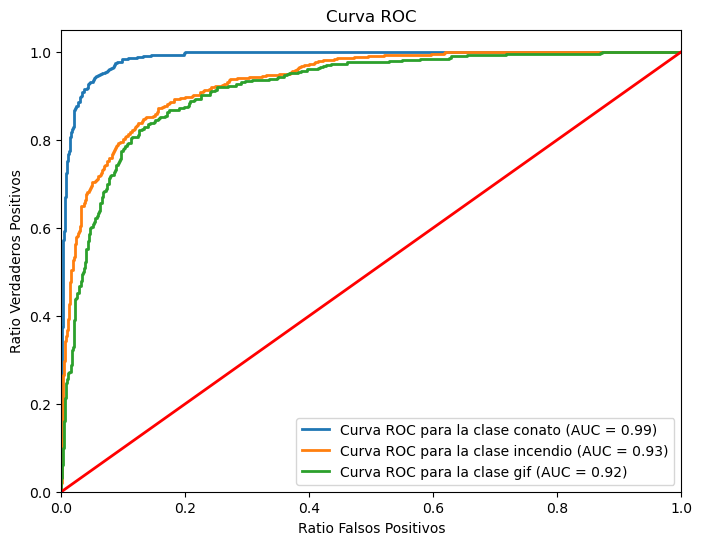

In [249]:
y_pred_prob = modelo_optimizado.predict_proba(X_test)

# Mapeo de clases
class_names = {0: 'conato', 1: 'incendio', 2: 'gif'}

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva ROC y el AUC
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el cálculo del AUC
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    # Usamos el nombre de la clase en lugar del índice
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Curva ROC para la clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

### Año 2017

In [546]:
bdif_2017 = bdif[bdif['año'] == 2017]
bdif_2017.shape

(8044, 30)

In [547]:
bdif_2017['claseincendio'].value_counts()

claseincendio
0    4979
1    3023
2      42
Name: count, dtype: int64

In [548]:
# Separamos las variables descriptivas de la variable objetivo
X_2017 = bdif_2017.drop(columns=['claseincendio'])
y_2017 = bdif_2017['claseincendio']

# le pasamos el pipeline a los datos de 2017
X_2017 = pipeline.transform(X_2017)

In [549]:
# Lo pasamos a dataframe
X_2017 = pd.DataFrame(X_2017, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_2017.filter(regex='^cat').columns
X_2017[dummies] = X_2017[dummies].astype(int)

# Eliminamos los prefijos
X_2017.columns = X_2017.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Mostrar el resultado
X_2017.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_octubre,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde
0,0.093879,0.315230,0.689768,0.925221,0.0000,0.457350,0.750000,0.035032,0.244485,0.671141,...,0,0,1,0,0,0,0,0,0,1
1,0.093879,0.256198,0.698204,0.922781,0.0000,0.488203,0.750000,0.035032,0.244485,0.671141,...,0,0,0,0,1,0,0,0,0,1
2,0.093879,0.342385,0.693375,0.926682,0.0575,0.384755,0.750000,0.035032,0.244485,0.671141,...,0,0,0,0,1,0,0,1,0,0
3,0.093879,0.342385,0.693375,0.926682,0.0000,0.593466,0.409091,0.066589,0.181150,0.087248,...,0,0,0,0,0,1,0,0,0,1
4,0.093879,0.407320,0.694640,0.928084,0.0000,0.537205,0.409091,0.066589,0.181150,0.087248,...,0,0,1,0,0,0,0,0,0,1


In [550]:
# Nos aseguramos de que el índice sea el mismo
X_2017.reset_index(drop=True, inplace=True)
y_2017.reset_index(drop=True, inplace=True)

# Lo combinamos en un dataframe para poder seguir realizando el preprocesamiento de los datos
datos_2017 = pd.concat([X_2017, y_2017], axis=1)
datos_2017.rename(columns={y_2017.name: 'claseincendio'}, inplace=True)

# Mostramos el resultado
datos_2017.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde,claseincendio
0,0.093879,0.315230,0.689768,0.925221,0.0000,0.457350,0.750000,0.035032,0.244485,0.671141,...,0,1,0,0,0,0,0,0,1,0
1,0.093879,0.256198,0.698204,0.922781,0.0000,0.488203,0.750000,0.035032,0.244485,0.671141,...,0,0,0,1,0,0,0,0,1,1
2,0.093879,0.342385,0.693375,0.926682,0.0575,0.384755,0.750000,0.035032,0.244485,0.671141,...,0,0,0,1,0,0,1,0,0,0
3,0.093879,0.342385,0.693375,0.926682,0.0000,0.593466,0.409091,0.066589,0.181150,0.087248,...,0,0,0,0,1,0,0,0,1,0
4,0.093879,0.407320,0.694640,0.928084,0.0000,0.537205,0.409091,0.066589,0.181150,0.087248,...,0,1,0,0,0,0,0,0,1,1


In [551]:
# Filtramos la selección de características
datos_2017 = datos_2017[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]
datos_2017.shape

(8044, 37)

In [552]:
X_datos_2017 = datos_2017.drop(columns=['claseincendio'])
y_datos_2017 = datos_2017['claseincendio']

In [553]:
# Aplicar submuestreo con ENN
enn = EditedNearestNeighbours(n_neighbors=5, kind_sel='all')
X_sub, y_sub = enn.fit_resample(X_datos_2017, y_datos_2017)

In [554]:
# Aplicamos submuestreo con Tomek Links
tomek = TomekLinks(sampling_strategy='auto')
X_resampled, y_resampled = tomek.fit_resample(X_sub, y_sub)

# Creamos el dataframe
bdif_sub_2017= pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['claseincendio'])], axis=1)

# Mostramos el resultado final
print(bdif_sub_2017['claseincendio'].value_counts())

claseincendio
0    880
1    184
2     42
Name: count, dtype: int64


In [555]:
# Separamos en variables descriptivas y objetivo
X_2017 = bdif_sub_2017.drop(columns=['claseincendio'])
y_2017 = bdif_sub_2017['claseincendio']

### Submuestreo

In [556]:
# {0:int(1.5*y_2017.value_counts()[2]), 1:int(1.5*y_2017.value_counts()[2])}
rus = RandomUnderSampler(sampling_strategy={0:int(1.5*y_2017.value_counts()[2]), 1:int(1.5*y_2017.value_counts()[2])}, random_state=42)

# Aplicar el submuestreo
X_2017, y_2017 = rus.fit_resample(X_2017, y_2017)

print(Counter(y_2017))

Counter({0: 63, 1: 63, 2: 42})


### Sobremuestreo

In [543]:
#X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(X_2017, y_2017, test_size=0.2, random_state=42, stratify=y_2017)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_2017, y_2017 = smote.fit_resample(X_2017, y_2017)

#print(f"Distribución de clases en el conjunto de train: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_2017)}")

Distribución de clases en el conjunto de test: Counter({0: 63, 1: 63, 2: 63})


### Si queremos reentrenar con los datos de 2017

In [519]:
# Si quisieramos entrenar el modelo con los datos de 2017
modelo_final = CatBoostClassifier(
    iterations=400,
    learning_rate=0.07629814459517262,
    depth=10,
    l2_leaf_reg=4.355777835208367,
    random_strength=3.8442029458960665,
    loss_function='MultiClass',
    verbose=100
)
modelo_final.fit(X_train, y_train)

0:	learn: 1.0529215	total: 73.8ms	remaining: 29.5s
100:	learn: 0.3355049	total: 7.14s	remaining: 21.2s
200:	learn: 0.2112130	total: 13.8s	remaining: 13.7s
300:	learn: 0.1491655	total: 20.7s	remaining: 6.81s
399:	learn: 0.1114677	total: 27.4s	remaining: 0us


### Sin reentrenar con datos de 2017

In [373]:
#X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(X_2017, y_2017, test_size=0.2, random_state=42)

In [557]:
y_pred_2017 = modelo_optimizado.predict(X_2017)
# Mostrar las métricas de clasificación
print(classification_report(y_2017, y_pred_2017))

              precision    recall  f1-score   support

           0       0.87      0.98      0.93        63
           1       0.78      0.63      0.70        63
           2       0.63      0.69      0.66        42

    accuracy                           0.78       168
   macro avg       0.76      0.77      0.76       168
weighted avg       0.78      0.78      0.77       168



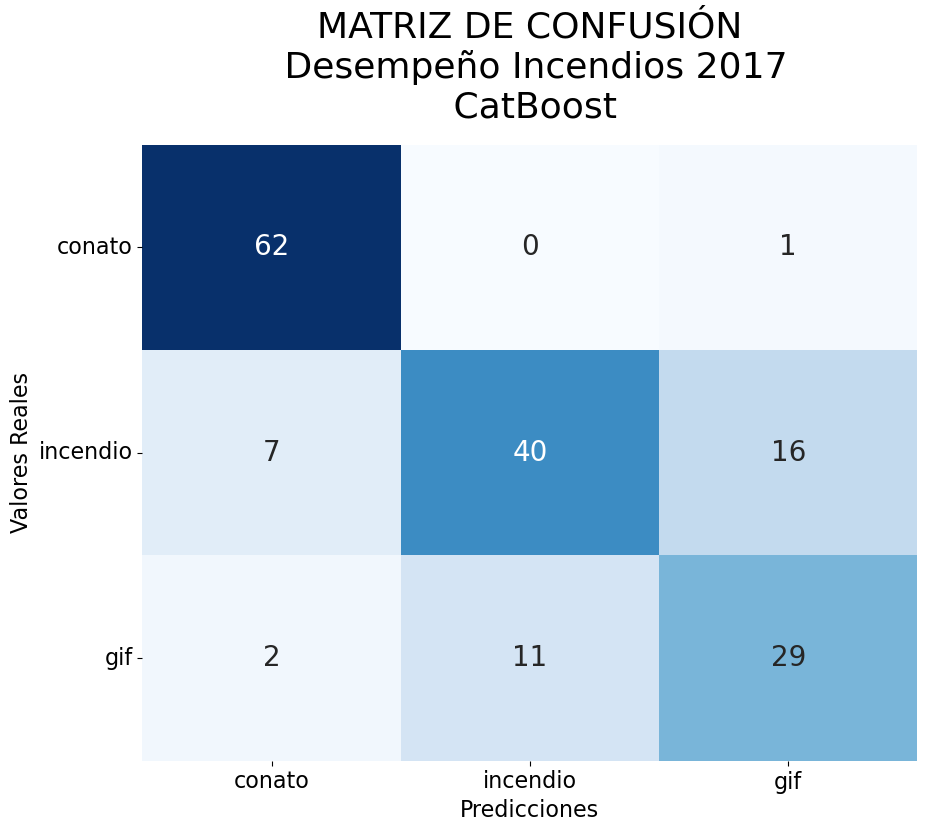

In [558]:
cm = confusion_matrix(y_2017, y_pred_2017, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20},cbar=False)

plt.title("MATRIZ DE CONFUSIÓN\n Desempeño Incendios 2017\n CatBoost", fontsize=26, pad=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

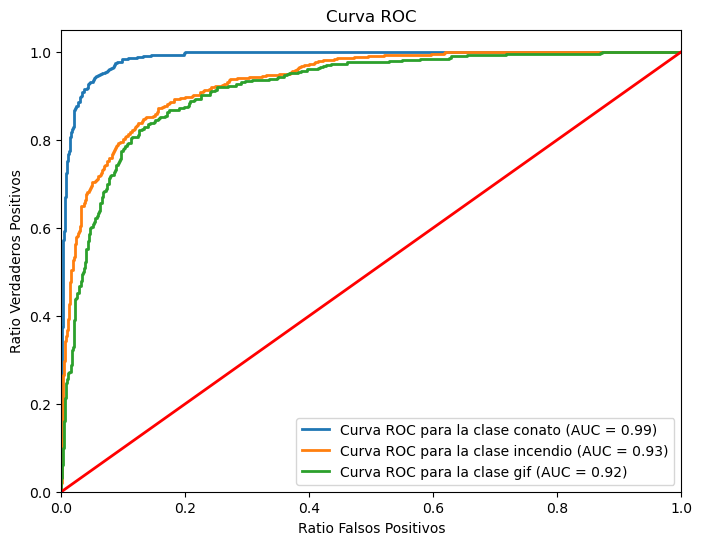

In [559]:
y_pred_prob = modelo_optimizado.predict_proba(X_test)

# Diccionario para asignar nombres a las clases
class_names = {0: 'conato', 1: 'incendio', 2: 'gif'}

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva ROC y el AUC
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el cálculo del AUC
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    # Usamos el nombre de la clase en lugar del índice
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Curva ROC para la clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

#### Fuentes de datos:

1. **AEMET**: Los datos utilizados en este análisis provienen de la **Agencia Estatal de Meteorología (AEMET)**. Los datos están sujetos a las [condiciones de uso de AEMET](https://www.aemet.es/es/portada), y deben ser utilizados con la debida citación.
2. **EGIF**: Los datos utilizados en este análisis provienen de la **Estadística General de Incendios Forestales (EGIF)**, gestionada por el **Ministerio para la Transición Ecológica y el Reto Demográfico (MITECO)**. Los datos deben ser utilizados de acuerdo con las [condiciones de uso de la EGIF](https://www.miteco.gob.es/es/biodiversidad/temas/incendios-forestales/estadisticas-datos.aspx).
3. **NGMEP (Nomenclátor Geográfico de Municipios y Entidades de Población)**: Los datos utilizados en este análisis provienen del **Nomenclátor Geográfico de Municipios y Entidades de Población (NGMEP)**, proporcionado por el **Centro Nacional de Información Geográfica (CNIG)**. Los datos están sujetos a la licencia de [Datos Abiertos del CNIG](https://astronoomia.ign.es/web/ign/portal). Se debe proporcionar citación adecuada al utilizar los datos.
4. **Climate Data Store (CDS)**: Los datos utilizados en este análisis provienen del **Climate Data Store (CDS)**, específicamente del indicador de peligro de incendio **FWI** derivado de proyecciones climáticas para Europa. Los datos están sujetos a la [licencia de uso de CDS](https://cds.climate.copernicus.eu/#!/home), y deben ser utilizados con la debida citación.
5. **INE (Instituto Nacional de Estadística)**: Los datos utilizados en este análisis provienen de las **Series de población por provincia (1900-2001)**, las **principales series de población desde 1998** y del **Código INE**. Los datos están sujetos a las [condiciones de uso del INE](https://www.ine.es/jaxiT3/Datos.htm?t=2865), y deben ser utilizados con la debida citación.